# Передбачення зарплат на IT-ринку України

У цьому завданні ви працюватимете з реальними даними з [зарплатного опитування DOU.ua за травень 2016р](https://dou.ua/lenta/articles/salary-report-may-june-2016/). Ви реалізуєте зважену лінійну регресію, яка передбачає зарплати Java-інженерів, та навчите свою модель за допомогою градієнтного спуску.

Заповніть пропущений код в розділі «Моделювання» (позначено коментарями) та запустіть розділ «Тестування», щоб перевірити його правильність.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
%matplotlib inline

In [4]:
%load_ext ipython_unittest

## Підготовка даних

In [5]:
df_salaries = pd.read_csv("data/2016_may_final.csv")

Оберемо тільки Java-інженерів з-поміж усіх респондентів.

In [6]:
df_java = pd.DataFrame(df_salaries[(df_salaries["Язык.программирования"] == "Java") &
                                   (df_salaries["cls"] == "DEV")])

Перейменуємо деякі колонки:

In [7]:
df_java.rename(
    columns={
        "exp": "TotalExperience",
        "loc": "Location"
    },
    inplace=True
)

Закодуємо рівень англійської мови числами від 1 (найнижчий) до 5 (найвищий):

In [8]:
df_java["EnglishLevel"] = df_java["Уровень.английского"].map({
    "элементарный": 1,
    "ниже среднего": 2,
    "средний": 3,
    "выше среднего": 4,
    "продвинутый": 5
})

Закодуємо колонку Location (найбільші IT-міста або "other") за допомогою one-hot encoding:

In [9]:
city_columns = [
    "LocationOther",
    "LocationDnipro",
    "LocationKyiv",
    "LocationLviv",
    "LocationOdesa",
    "LocationKharkiv"
]
df_java[city_columns] = pd.get_dummies(df_java["Location"])

Відберемо такі ознаки:

* Загальна кількість років досвіду
* Рівень англійської мови
* Місто

In [10]:
feature_columns = ["TotalExperience", "EnglishLevel"] + city_columns
df_X = df_java[feature_columns]
df_y = df_java[["salary"]]

In [11]:
print("X shape:", df_X.shape)

X shape: (929, 8)


In [12]:
df_X.head(10)

,TotalExperience,EnglishLevel,LocationOther,LocationDnipro,LocationKyiv,LocationLviv,LocationOdesa,LocationKharkiv
5,0.5,3,1,0,0,0,0,0
7,5.0,1,0,0,1,0,0,0
17,0.0,3,0,0,1,0,0,0
27,4.0,3,0,0,1,0,0,0
28,6.0,4,0,0,1,0,0,0
39,3.0,4,0,1,0,0,0,0
46,2.0,4,0,0,0,0,0,1
49,3.0,3,0,0,1,0,0,0
59,2.0,3,0,0,0,0,0,1
89,1.0,5,0,0,1,0,0,0


In [13]:
df_y.head(10)

,salary
5,500
7,1600
17,600
27,3400
28,2880
39,1425
46,1700
49,1800
59,1235
89,1200


Розділимо вибірку на навчальну та тестову:

In [14]:
training_set_size = 0.8

In [15]:
dataset_assignment = np.random.uniform(size=len(df_X))

X_train = df_X[dataset_assignment <= training_set_size].values
y_train = df_y[dataset_assignment <= training_set_size].values.flatten()

X_test = df_X[dataset_assignment > training_set_size].values
y_test = df_y[dataset_assignment > training_set_size].values.flatten()

Щоб градієнтний спуск швидше збігався, нормалізуємо навчальну вибірку так, щоб кожна ознака мала $\mu = 0, \sigma = 1$:

$ x' = \frac{x - \bar{x}}{\sigma}$

In [16]:
feature_means = np.average(X_train, axis=0)
feature_sigmas = np.std(X_train, axis=0)

In [17]:
X_train = (X_train - feature_means) / feature_sigmas
X_test = (X_test - feature_means) / feature_sigmas

Додаємо уявну ознаку $x_0 = 1$ (intercept term).

In [18]:
if not np.all(X_train[:, 0] == 1):
    X_train = np.insert(X_train, 0, values=1, axis=1)
    
if not np.all(X_test[:, 0] == 1):
    X_test = np.insert(X_test, 0, values=1, axis=1)

In [19]:
print("X train: ", X_train.shape)
print("y train: ", y_train.shape)
print()
print("X test:  ", X_test.shape)
print("y test:  ", y_test.shape)

X train:  (741, 9)
y train:  (741,)

X test:   (188, 9)
y test:   (188,)


## Моделювання

Реалізуйте функцію гіпотези лінійної регресії в матричній формі.

In [20]:
def predict_linear(theta, X):
    # =============== TODO: Your code here ===============
    # Compute the hypothesis function for linear regression.
    return np.dot(X, theta)
    # ====================================================

Реалізуйте функцію зважування всіх навчальних прикладів $x^{(i)}$, якщо нам дана точка передбачення $x$.

In [21]:
def get_example_weights(X, x_pred, tau):
    # =============== TODO: Your code here ===============
    # Compute the weight for each example, given the
    # prediction point (x_pred).
    weights = np.array([np.exp(  (-(np.dot(X[i]-x_pred, X[i]-x_pred)))  /(2*(tau**2))) for i in range(X.shape[0])])
    # ====================================================
    return weights

Реалізуйте функцію втрат зваженої лінійної регресії. Подумайте, як обчислити цей вираз відразу в матричному вигляді.

In [22]:
def cost_function(theta, X, y, weights):
    # =============== TODO: Your code here ===============
    # Given the currently learned model weights (theta),
    # compute the overall loss on the training set (X),
    # taking the weights into account.
    return np.sum(np.matmul(np.square(predict_linear(theta, X) - y), weights)) / (2 * len(y))
# ====================================================

Реалізуйте обчислення градієнта функції втрат зваженої лінійної регресії. Подумайте, як обчислити цей вираз відразу в матричному вигляді.

In [23]:
def cost_function_gradient(theta, X, y, weights):
    # =============== TODO: Your code here ===============
    # Given the currently learned model weights (theta),
    # compute the gradient of the cost function on the
    # training set (X), taking the weights into account.

    return ((predict_linear(theta, X)-y)*weights).dot(X) / X.shape[0]
    # ====================================================

Реалізуйте один крок градієнтного спуску.

In [24]:
def update_model_weights(theta, learning_rate, cost_gradient):
    # =============== TODO: Your code here ===============
    # Given the learning rate and the gradient of the
    # cost function, take one gradient descent step and
    # return the updated vector theta.
    
    return theta - learning_rate * cost_gradient
    # ====================================================

**Навчаємо модель:**

In [29]:
def gradient_descent(X, y, weights, loss_fun, grad_fun, learning_rate, convergence_threshold, max_iters, verbose=False):
    theta = np.zeros(X.shape[1])
    losses = []
    
    for i in range(max_iters):
        loss = loss_fun(theta, X, y, weights)
        losses.append(loss)
        
        if verbose:
            print("Iteration: {0:3} Loss: {1}".format(i + 1, loss))

        if len(losses) > 2 and np.abs(losses[-1] - losses[-2]) <= convergence_threshold:
            break
        
        grad = grad_fun(theta, X, y, weights)
        theta = update_model_weights(theta, learning_rate, grad)
        
    return theta, np.array(losses)

## Передбачення нових даних

In [30]:
def predict_weighted_linear(X, y, x_pred, verbose=False):
    weights = get_example_weights(X, x_pred, tau=0.1)
    theta, losses = gradient_descent(
        X,
        y,
        weights,
        loss_fun=cost_function,
        grad_fun=cost_function_gradient,
        learning_rate=0.005,
        convergence_threshold=0.0001,
        max_iters=500,
        verbose=verbose
    )
    return predict_linear(theta, x_pred)

In [33]:
x_pred = X_train[4]

In [28]:
predicted = predict_weighted_linear(X_train, y_train, x_pred, verbose=True)

Iteration:   1 Loss: 2051.275762424122
[ -3.27845509   0.29363146  -2.67014128   1.39793795 -11.14642043
   2.85826953   1.26480915   0.76222533   1.39793795]
Iteration:   2 Loss: 2050.4935107209703
[ -3.27781037   0.29357369  -2.66961618   1.39766304 -11.14422845
   2.85770744   1.26456042   0.76207543   1.39766304]
Iteration:   3 Loss: 2049.711566651771
[ -3.27716578   0.29351593  -2.6690912    1.39738818 -11.14203691
   2.85714547   1.26431174   0.76192557   1.39738818]
Iteration:   4 Loss: 2048.929930095543
[ -3.27652132   0.29345817  -2.66856631   1.39711338 -11.13984579
   2.8565836    1.26406311   0.76177573   1.39711338]
Iteration:   5 Loss: 2048.148600931351
[ -3.27587698   0.29340043  -2.66804153   1.39683864 -11.13765511
   2.85602185   1.26381453   0.76162593   1.39683864]
Iteration:   6 Loss: 2047.3675790383077
[ -3.27523277   0.29334271  -2.66751685   1.39656394 -11.13546486
   2.8554602    1.26356599   0.76147615   1.39656394]
Iteration:   7 Loss: 2046.5868642955743
[ -3

Оцінимо, наскільки модель помиляється на тестовій вибірці:

In [29]:
y_test_pred = np.array([predict_weighted_linear(X_test, y_test, X_test[i]) for i in range(len(y_test))])

In [30]:
df_residuals = pd.DataFrame(y_test - y_test_pred, columns=["residual"])

[Text(0.5,1,'Error Distribution')]

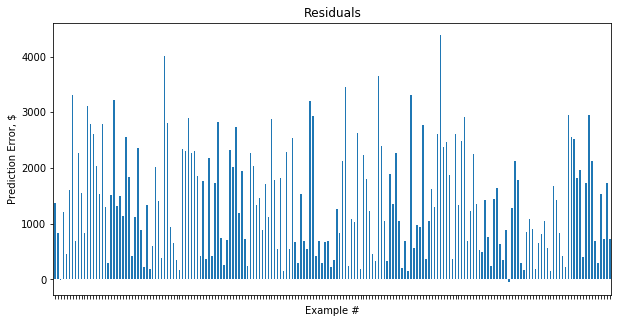

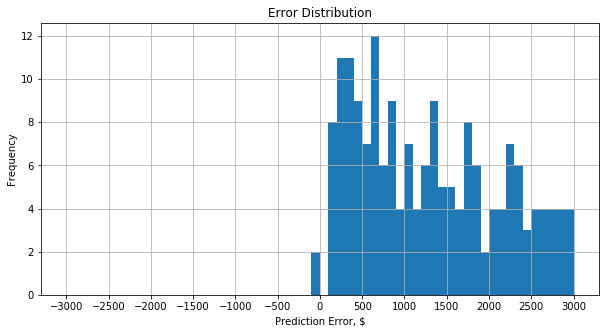

In [31]:
ax = df_residuals.plot.bar(figsize=(10, 5))
ax.legend().remove()
ax.get_xaxis().set(ticklabels=[])
ax.set(xlabel="Example #")
ax.set(ylabel="Prediction Error, $")
ax.set(title="Residuals")

bins = np.arange(-3000, 3001, 100)
ticks = np.arange(-3000, 3001, 500)

ax = df_residuals.hist(bins=bins, figsize=(10, 5))[0][0]
ax.set(xticks=ticks)
ax.set(xlabel="Prediction Error, $")
ax.set(ylabel="Frequency")
ax.set(title="Error Distribution")

## Тестування

Запустіть комірку нижче, щоб перевірити правильність вашого коду:

In [32]:
%%unittest_main

class WLRTests(unittest.TestCase):

    x = np.array([1, -0.5, 3, 1])
    X = np.array([
        [1, -0.5, 3, 1],
        [2, 8, -0.33, 5],
        [0, 0, 0, 0]
    ])
    y = np.array([40, 100, 12])
    theta = np.array([2, 5, 7, 9])
    eps = 0.001

    def assertFloatEquals(self, a, b):
        self.assertTrue(np.abs(a - b) < self.eps)
    
    def assertArrayEquals(self, a, b):
        a = np.array(a)
        b = np.array(b)
        self.assertEqual(a.shape, b.shape)
        self.assertTrue(np.all(np.abs(a - b) < self.eps))
    
    def test_predict_linear_should_compute_correct_prediction_for_1_example(self):
        expected = 29.5
        actual = predict_linear(self.theta, self.x)
        self.assertEqual(actual, expected)
    
    def test_predict_linear_should_compute_correct_predictions_for_multiple_examples(self):
        expected = [29.5, 86.69, 0]
        actual = (predict_linear(self.theta, self.X))
        self.assertArrayEquals(actual, expected)
    
    def test_get_example_weights_should_return_properly_shaped_vector(self):
        weights = get_example_weights(self.X, self.x, tau=5)
        self.assertTrue(weights.shape[0] == self.X.shape[0])
    
    def test_get_example_weights_should_compute_correct_weights(self):
        expected = [1.000, 0.134, 0.798]
        actual = get_example_weights(self.X, self.x, tau=5)
        self.assertArrayEquals(actual, expected)
    
    def test_cost_function_should_compute_correct_cost_unweighted(self):
        weights = np.ones(self.X.shape[0])
        expected = 71.901
        actual = cost_function(self.theta, self.X, self.y, weights)
        self.assertFloatEquals(actual, expected)
    
    def test_cost_function_should_compute_correct_cost_weighted(self):
        weights = np.array([0.5, 0.1, 0.28])
        expected = 18.860
        actual = cost_function(self.theta, self.X, self.y, weights)
        self.assertFloatEquals(actual, expected)

    def test_cost_gradient_should_return_properly_shaped_vector(self):
        weights = np.ones(self.X.shape[0])
        grad = cost_function_gradient(self.theta, self.X, self.y, weights)
        self.assertTrue(grad.shape == self.theta.shape)
        
    def test_cost_gradient_should_compute_correct_gradient_unweighted(self):
        weights = np.ones(self.X.shape[0])
        expected = [-37.12, -101.23, -27.108, -77.05]
        actual = cost_function_gradient(self.theta, self.X, self.y, weights)
        print(actual, expected)
        self.assertArrayEquals(actual, expected)
    
    def test_cost_gradient_should_compute_correct_gradient_weighted(self):
        weights = np.array([0.5, 0.1, 0.28])
        expected = [-7.912, -8.023, -15.311, -11.905]
        actual = cost_function_gradient(self.theta, self.X, self.y, weights)
        print(actual, expected)
        self.assertArrayEquals(actual, expected)
    
    def test_update_model_weights_should_not_update_when_gradient_is_zero(self):
        grad = np.zeros(self.theta.shape[0])
        theta_new = update_model_weights(self.theta, learning_rate=1, cost_gradient=grad)
        self.assertArrayEquals(theta_new, self.theta)
    
    def test_update_model_weights_should_update_with_complete_gradient_if_learning_rate_is_one(self):
        grad = np.array([1.35, -0.89, 0.16, 0.98])
        expected = [0.65, 5.89, 6.84, 8.02]
        actual = update_model_weights(self.theta, learning_rate=1, cost_gradient=grad)
        self.assertArrayEquals(actual, expected)
    
    def test_update_model_weights_should_take_learning_rate_into_account(self):
        grad = np.array([1.35, -0.89, 0.16, 0.98])
        expected = [1.730, 5.178, 6.968, 8.804]
        actual = update_model_weights(self.theta, learning_rate=0.2, cost_gradient=grad)
        self.assertArrayEquals(actual, expected)

[-12.37333333 -33.74333333  -9.0359     -25.68333333] [-37.12, -101.23, -27.108, -77.05]
[-2.63733333 -2.67433333 -5.10359    -3.96833333] [-7.912, -8.023, -15.311, -11.905]


Fail

..FF........
FAIL: test_cost_gradient_should_compute_correct_gradient_unweighted (__main__.WLRTests)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "Cell Tests", line 64, in test_cost_gradient_should_compute_correct_gradient_unweighted
  File "Cell Tests", line 21, in assertArrayEquals
AssertionError: False is not true

FAIL: test_cost_gradient_should_compute_correct_gradient_weighted (__main__.WLRTests)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "Cell Tests", line 71, in test_cost_gradient_should_compute_correct_gradient_weighted
  File "Cell Tests", line 21, in assertArrayEquals
AssertionError: False is not true

----------------------------------------------------------------------
Ran 12 tests in 0.006s

FAILED (failures=2)


<unittest.runner.TextTestResult run=12 errors=0 failures=2>